# Cross-Layer Equalization (CLE) 

### CLE on a FX-Graph quantized PyTorch model


In this tutorial, we take a PyTorch ResNet model, and we observe the effect of CLE on its quantization. 
CLE is a technique that was first proposed by Nagel et al. at Qualcomm in their [Data Free Quantization](https://arxiv.org/pdf/1906.04721) paper, and involves manipulating weight tensors so that the dynamic ranges of the individual channels match each other. 
This is done by equalizing the dynamic range of the output channels, and manipulating the input channel tensors of the next layer so that the output of the next layer remains the same. If multiple adjacent layers are CLE'd, this may take a few iterations to stabilize.

The purpose of CLE is so that the weight quantization is less likely to cause outliers. 
It is said to be more effective in the case of per-tensor quantization of weights, but in the paper is said to also give some benefit in the case of per-channel quantization, perhaps due to its affect on the activations.


In this tutorial (mostly for the sake of showing how something like
this can be coded), we will see that (in the context of our very unimpressive evaluation set of 2 images) it marginally improves performance.
We'll also take a look at how it affects the distribution of the weight tensors. FInally, we'll also be using a graph-based technique to automate finding the CLE module pairs, rather than filling them all in manually as the PyTorch CLE API expects.

In [1]:
import os
from pathlib import Path

from quant_vis.histograms import (
    add_sensitivity_analysis_hooks,
    plot_quant_act_SA_hist,
    plot_quant_weight_hist,
)
import torch
from torch import fx
from torch.ao.quantization._equalize import equalize
from torch.ao.quantization._learnable_fake_quantize import (
    _LearnableFakeQuantize as LearnableFakeQuantize,
)
from torch.ao.quantization.qconfig_mapping import QConfigMapping
from torch.ao.quantization.quantize_fx import prepare_qat_fx
import torch.quantization as tq

from evaluate import evaluate
from model.resnet import resnet18
from quant_vis.utils.prop_data import forward_and_backprop_an_image
from utils.graph_manip import (
    float_convbn_to_conv,
    qat_convbn_to_conv,
    get_previous_module_node,
)
from utils.qconfigs import (
    fake_quant_act,
    fake_quant_weight,
    learnable_act,
    learnable_weights,
)


# Intialize model
model = resnet18(pretrained=True)

/home/oscar/miniconda3/envs/BQ/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/oscar/miniconda3/envs/BQ/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## CLE

We start by graph-tracing the floating-point ResNet model. This is not strictly required, but it help us automate finding the CLE-pairs in the model. We also fuse Conv and BatchNorm layers in the float model, prior to CLE.

In [2]:
# Graph-trace the model
model.train()
float_traced_model = fx.symbolic_trace(model)

# Merge all batchnorms into preceding convs
float_traced_model.eval()
float_traced_model = float_convbn_to_conv(float_traced_model)


The CLE API takes in a list of lists, where each sub-list represents the pairs on modules to perform CLE on. 
Rather than provide this manually, I figured it was a good opportunity to practice graph-tracing a model, plus automating it makes it more flexible to different models.


I wrote some code to iterate through the graph, finding all CLE pairs based on a set of criteria (for a given module with weights, find the previous Conv or Linear layer,
as long as no "CLE-breaking" operations in between (e.g. `add`, `avgpool`, etc.)).


In [3]:
# Iterate through graph, find CLE layer pairs. See
# `get_previous_module_node` for details.
pairs = []
for node in float_traced_model.graph.nodes:
    if node.op == "call_module":
        module = float_traced_model.get_submodule(node.target)
        if hasattr(module, "weight"):
            prev_node = get_previous_module_node(
                float_traced_model,
                node,
                (torch.nn.Conv2d, torch.nn.Linear),
                CLE_compatible=True,
            )
            if prev_node:
                pairs.append([prev_node.target, node.target])

We can print the CLE pairs to see which modules will have CLE performed between them.

In [4]:
pairs

[['layer1.0.conv1', 'layer1.0.conv2'],
 ['layer1.1.conv1', 'layer1.1.conv2'],
 ['layer2.0.conv1', 'layer2.0.conv2'],
 ['layer2.1.conv1', 'layer2.1.conv2'],
 ['layer3.0.conv1', 'layer3.0.conv2'],
 ['layer3.1.conv1', 'layer3.1.conv2'],
 ['layer4.0.conv1', 'layer4.0.conv2'],
 ['layer4.1.conv1', 'layer4.1.conv2']]

We can also print out the entire model graph, for reference:

In [5]:
float_traced_model.graph.print_tabular()

opcode         name                   target                                                      args                                     kwargs
-------------  ---------------------  ----------------------------------------------------------  ---------------------------------------  --------
placeholder    x                      x                                                           ()                                       {}
call_module    conv1                  conv1                                                       (x,)                                     {}
call_module    relu                   relu                                                        (conv1,)                                 {}
call_module    maxpool                maxpool                                                     (relu,)                                  {}
call_module    layer1_0_conv1         layer1.0.conv1                                              (maxpool,)                              


We then perform CLE.

In [6]:

# Perform CLE from torch.ao.quantization._equalize import equalize
cle_model = equalize(float_traced_model, pairs, threshold=1e-4, inplace=False)

## Quantization

Having done CLE, we now quantize the model with FX. 

In [7]:
# Define qconfigs
qconfig_global = tq.QConfig(activation=fake_quant_act, weight=fake_quant_weight)

# Assign qconfigs
qconfig_mapping = QConfigMapping()

# We loop through the modules so that we can access the `out_channels` attribute
for name, module in cle_model.named_modules():
    if hasattr(module, "out_channels"):
        qconfig = tq.QConfig(
            activation=learnable_act(range=2),
            weight=learnable_weights(channels=module.out_channels),
        )
        qconfig_mapping.set_module_name(name, qconfig)


# Do symbolic tracing and quantization
example_inputs = (torch.randn(1, 3, 224, 224),)
cle_model.eval()
fx_model_w_cle = prepare_qat_fx(cle_model, qconfig_mapping, example_inputs)


## Comparing the CLE performance to without CLE
For comparison, we also get an FX model without CLE. We do so by
performing FX quantization and fusing the BNs into the Convs.

In [8]:
qconfig_mapping = QConfigMapping()  
for name, module in model.named_modules():
    if hasattr(module, "out_channels"):
        qconfig = tq.QConfig(
            activation=learnable_act(range=2),
            weight=learnable_weights(channels=module.out_channels),
        )
        qconfig_mapping.set_module_name(name, qconfig)
fx_model_no_cle = prepare_qat_fx(model, qconfig_mapping, example_inputs)
fx_model_no_cle.eval()
fx_model_no_cle = qat_convbn_to_conv(fx_model_no_cle)

## Evaluation
We can see below that the CLE model does marginally ebtter than the non-CLE model! Congratulations, we used CLE to boost the performance of the quantized ResNet by a tad!

In [9]:
# Evaluate model
print("\nOriginal")
evaluate(model, "cpu", "Samoyed")

print("Evaluating a dog")
print("\nFX prepared, with CLE")
evaluate(fx_model_w_cle, "cpu", "Samoyed")

print("\nFX prepared, without CLE")
evaluate(fx_model_no_cle, "cpu", "Samoyed")


print("Evaluating a hen")
print("\nFX prepared, with CLE")
evaluate(fx_model_w_cle, "cpu", "hen")

print("\nFX prepared, without CLE")
evaluate(fx_model_no_cle, "cpu", "hen")

# We turn off PTQ observation, but keep fake-quant turned on
for name, module in fx_model_w_cle.named_modules():
    if hasattr(module, 'scale'):
        module.enable_param_learning()
for name, module in fx_model_no_cle.named_modules():
    if hasattr(module, 'scale'):
        module.enable_param_learning()


Original
Samoyed 0.8846225142478943
Arctic fox 0.045805174857378006
white wolf 0.0442761555314064
Pomeranian 0.005621383432298899
Great Pyrenees 0.004652013536542654


Evaluating a dog

FX prepared, with CLE
Samoyed 0.8991352319717407
Arctic fox 0.047292277216911316
white wolf 0.028051000088453293
Pomeranian 0.006247097626328468
Great Pyrenees 0.004566030576825142



FX prepared, without CLE
Samoyed 0.8830579519271851
Arctic fox 0.05734744668006897
white wolf 0.029428191483020782
Pomeranian 0.007522757165133953
Great Pyrenees 0.005933553446084261


Evaluating a hen

FX prepared, with CLE
hen 0.9735581278800964
cock 0.021832501515746117
partridge 0.0035500205121934414
ruffed grouse 0.0005399922374635935
house finch 5.0315316912019625e-05



FX prepared, without CLE
hen 0.9721574783325195
cock 0.02231685258448124
partridge 0.004193632397800684
ruffed grouse 0.0006087218062020838
house finch 6.149754335638136e-05




## Observing the effect of CLE on the tensors
To get some more intuition as to what's happening when we do CLE, we can observe the tensors. I've created a visualization tool that I think is quite neat which lives at https://github.com/OscarSavolainenDR/EasyQuant/tree/main . 

In [10]:
# ACTIVATION PLOTS
def create_act_plots(model, title):
    def conditions_met_forward_act_hook(module: torch.nn.Module, name: str) -> bool:
        if isinstance(module, LearnableFakeQuantize):
            # if '1' in name:
            print(f"Adding hook to {name}")
            return True
        return False

    # We add the hooks
    act_forward_histograms, act_backward_histograms = add_sensitivity_analysis_hooks(
        model, conditions_met=conditions_met_forward_act_hook, bit_res=8
    )

    forward_and_backprop_an_image(model)

    # Generate the forward and Sensitivity Analysis plots
    plot_quant_act_SA_hist(
        act_forward_histograms,
        act_backward_histograms,
        file_path=Path(os.path.abspath("") + f"/Histogram_plots/{title}"),
        sum_pos_1=[0.18, 0.60, 0.1, 0.1],  # location of the first mean intra-bin plot
        sum_pos_2=[0.75, 0.43, 0.1, 0.1],
        plot_title="SA act hists",
        module_name_mapping=None,
        bit_res=8,  # This should match the quantization resolution. Changing this will not change the model quantization, only the plots.
    )


# WEIGHT PLOTS
# Clear gradients with the sake of an otherwised unused optimizer
def create_weight_plots(model, title):
    from torch.optim import Adam

    optimizer = Adam(model.parameters(), lr=1)
    optimizer.zero_grad()

    # Check gradients cleared
    for parameter in model.parameters():
        assert parameter.grad is None

    # Produce new gradients
    forward_and_backprop_an_image(model)

    # Check gradients exist
    for parameter in model.parameters():
        assert parameter.grad is not None

    # Create the weight histogram plots, this time with Sensitivity Analysis
    # plots
    plot_quant_weight_hist(
        model,
        file_path=Path(os.path.abspath("") + f"/Histogram_plots/{title}"),
        plot_title="SA weight hists",
        module_name_mapping=None,
        conditions_met=None,
        # The below flag specifies that we should also do a Sensitivity
        # Analysis
        sensitivity_analysis=True,
    )


# Cross Layer Equalized plots
create_act_plots(fx_model_w_cle, "FX, with CLE")
create_weight_plots(fx_model_w_cle, "FX, with CLE")

# Original, non-Cross Layer Equalized plots
create_act_plots(fx_model_no_cle, "FX, no CLE")
create_weight_plots(fx_model_no_cle, "FX, no CLE")


WARNING - forward_hooks.py:139 - 
Adding forward activation histogram hooks. This will significantly slow down the forward calls for the targetted modules.


Adding hook to activation_post_process_0
Adding hook to activation_post_process_1
Adding hook to activation_post_process_2
Adding hook to activation_post_process_3
Adding hook to activation_post_process_4
Adding hook to activation_post_process_5
Adding hook to activation_post_process_6
Adding hook to activation_post_process_7
Adding hook to activation_post_process_8
Adding hook to activation_post_process_9
Adding hook to activation_post_process_10
Adding hook to activation_post_process_11
Adding hook to activation_post_process_12
Adding hook to activation_post_process_13
Adding hook to activation_post_process_14
Adding hook to activation_post_process_15
Adding hook to activation_post_process_16
Adding hook to activation_post_process_17
Adding hook to activation_post_process_18
Adding hook to activation_post_process_19
Adding hook to activation_post_process_20
Adding hook to activation_post_process_21
Adding hook to activation_post_process_22
Adding hook to activation_post_process_23
Ad

INFO - plot_histograms.py:383 - 
Plotting quantization sensitivity analysis plots for SA act hists. This can take a long time.
INFO - plot_histograms.py:279 - 
Plotting quantized weight tensor histograms for SA weight hists. This can take a long time.
WARNING - forward_hooks.py:139 - 
Adding forward activation histogram hooks. This will significantly slow down the forward calls for the targetted modules.


Adding hook to activation_post_process_0
Adding hook to activation_post_process_1
Adding hook to activation_post_process_2
Adding hook to activation_post_process_3
Adding hook to activation_post_process_4
Adding hook to activation_post_process_5
Adding hook to activation_post_process_6
Adding hook to activation_post_process_7
Adding hook to activation_post_process_8
Adding hook to activation_post_process_9
Adding hook to activation_post_process_10
Adding hook to activation_post_process_11
Adding hook to activation_post_process_12
Adding hook to activation_post_process_13
Adding hook to activation_post_process_14
Adding hook to activation_post_process_15
Adding hook to activation_post_process_16
Adding hook to activation_post_process_17
Adding hook to activation_post_process_18
Adding hook to activation_post_process_19
Adding hook to activation_post_process_20
Adding hook to activation_post_process_21
Adding hook to activation_post_process_22
Adding hook to activation_post_process_23
Ad

INFO - plot_histograms.py:383 - 
Plotting quantization sensitivity analysis plots for SA act hists. This can take a long time.
INFO - plot_histograms.py:279 - 
Plotting quantized weight tensor histograms for SA weight hists. This can take a long time.


See the [GitHub](https://github.com/OscarSavolainenDR/EasyQuant/blob/main/tutorials/SA_plots/SA_plots.ipynb) for more details, but the `blue` represents the distribution of the tensor, and the `green` represents how much each histogram bin contributes to the final output of the model given the specific input (in this case, a picture of a dog).

We can observe that the histogram of the weight tensor of an arbitrary layer does change a little bit relative to the quantization grid, 
which is what one would expect from CLE. However, interpreting that change is not super easy, at least in my opinion, which is perhaps a lesson in itself! 


**With CLE:**
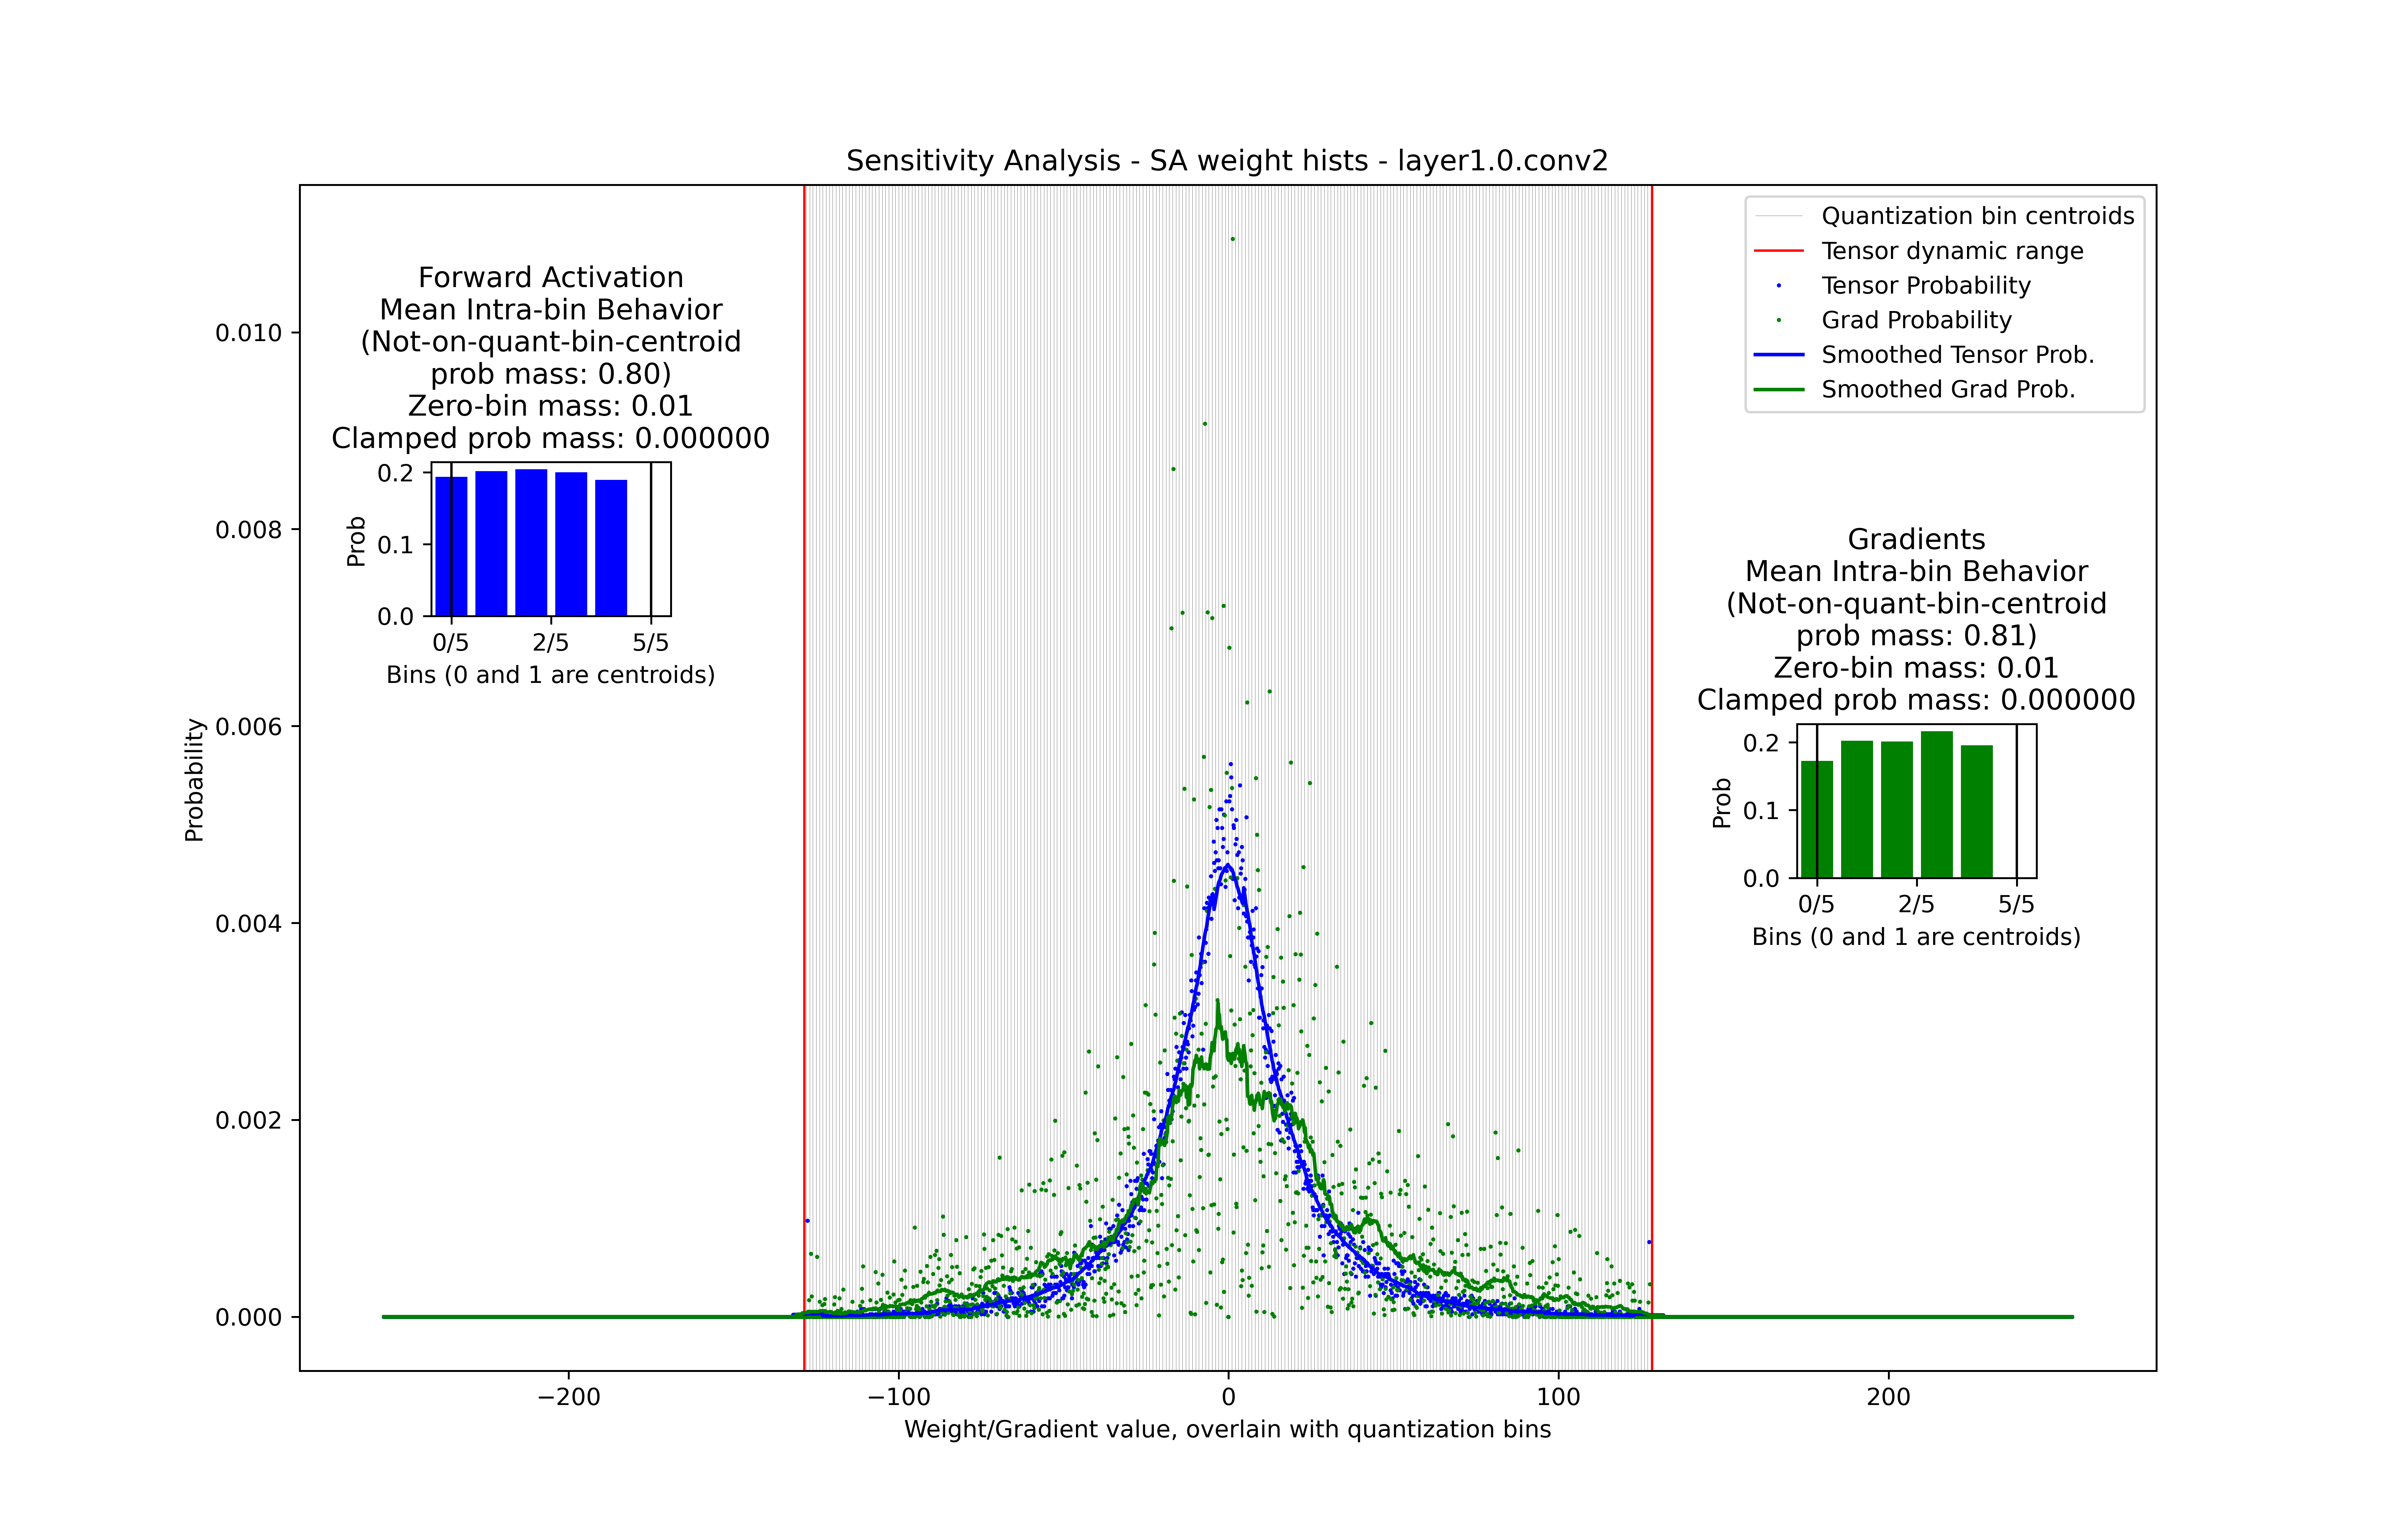

**Without CLE:**
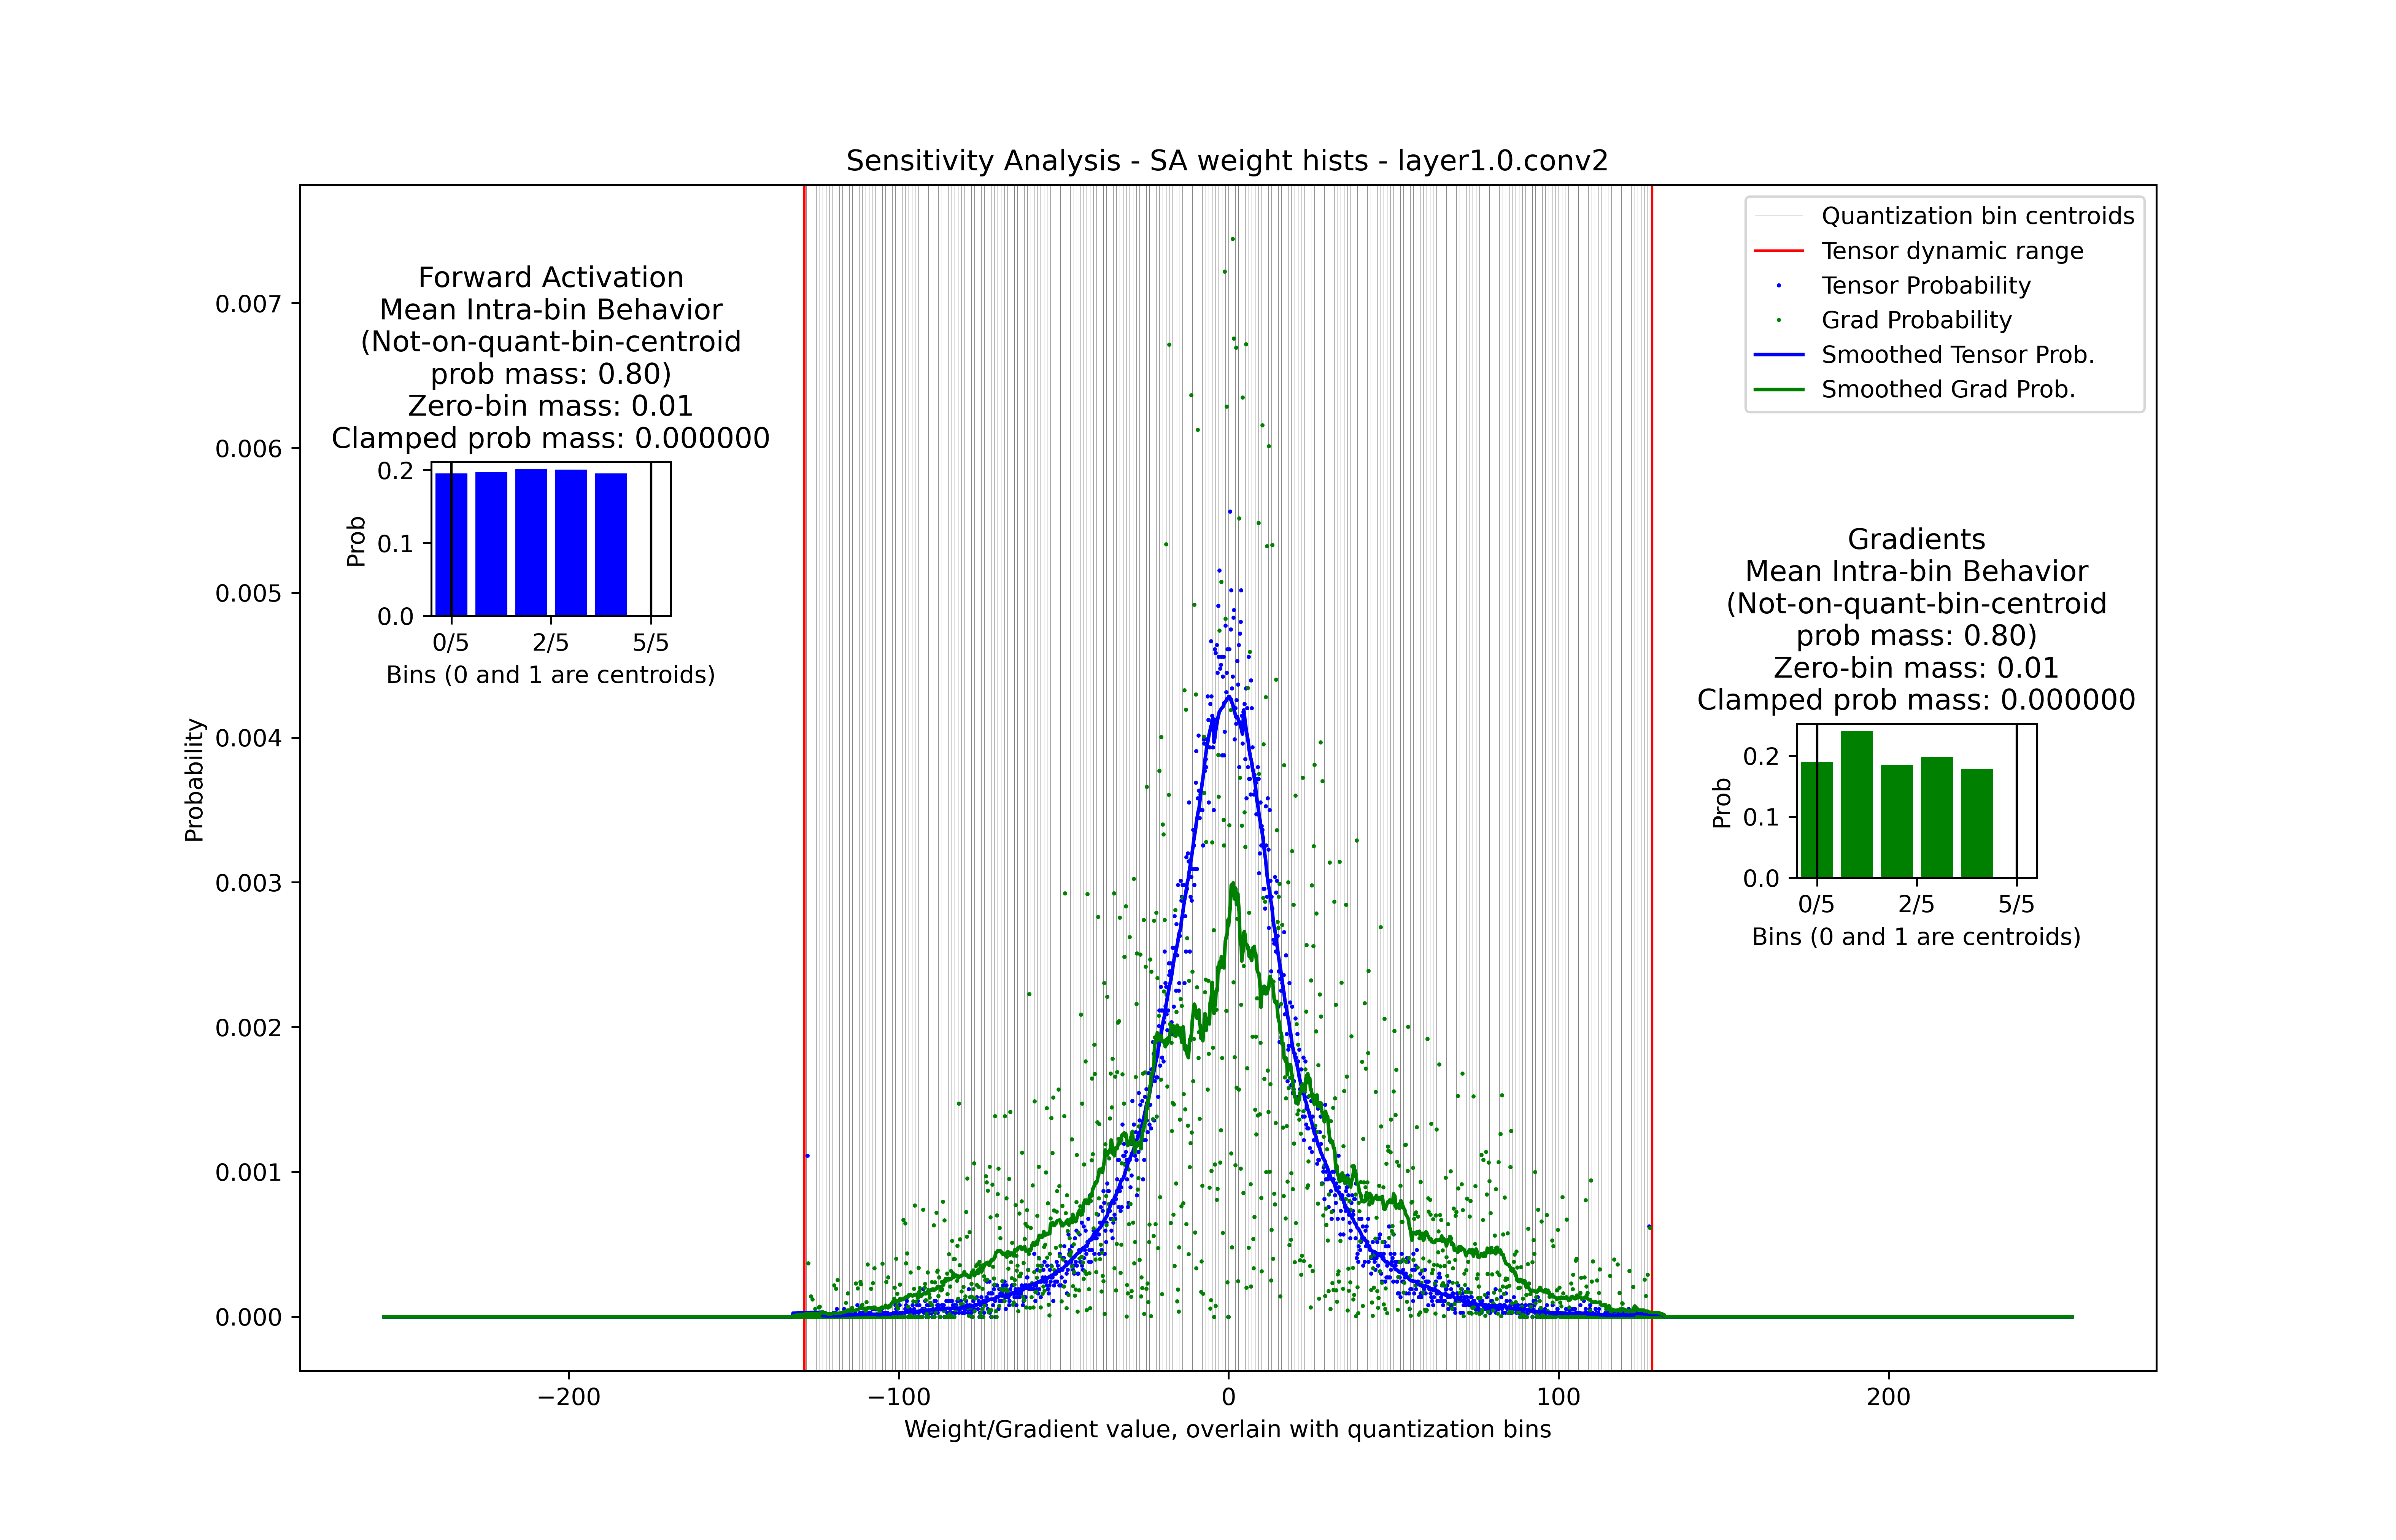


Lastly, we can print out some weight quantization parameters, and compare those of the CLE and non-CLE model.

In [11]:
# Print out some parameters before we do CLE
def print_scale_and_zp(model: torch.nn.Module, module_name: str):
    module = model.get_submodule(module_name)
    scale = module.scale
    zero_point = module.zero_point
    if len(scale) == 1:
        print(
            f"{module_name} scale and zero_point: {scale.item():.5}, {zero_point.item()}"
        )
    else:
        print(f"{module_name} scale and zero_point: {scale}, {zero_point}")

print("\nWithout CLE:")
print_scale_and_zp(fx_model_no_cle, "layer2.0.conv1.weight_fake_quant")

print("\nAfter CLE:")
print_scale_and_zp(fx_model_w_cle, "layer2.0.conv1.weight_fake_quant")


Without CLE:
layer2.0.conv1.weight_fake_quant scale and zero_point: Parameter containing:
tensor([0.0006, 0.0006, 0.0005, 0.0004, 0.0006, 0.0008, 0.0004, 0.0007, 0.0006,
        0.0007, 0.0010, 0.0005, 0.0008, 0.0004, 0.0004, 0.0006, 0.0009, 0.0005,
        0.0008, 0.0008, 0.0007, 0.0006, 0.0009, 0.0010, 0.0007, 0.0008, 0.0008,
        0.0007, 0.0011, 0.0004, 0.0005, 0.0008, 0.0004, 0.0006, 0.0006, 0.0009,
        0.0007, 0.0008, 0.0006, 0.0006, 0.0007, 0.0009, 0.0017, 0.0007, 0.0004,
        0.0004, 0.0005, 0.0009, 0.0005, 0.0010, 0.0008, 0.0006, 0.0008, 0.0004,
        0.0006, 0.0006, 0.0005, 0.0004, 0.0005, 0.0014, 0.0004, 0.0006, 0.0004,
        0.0005, 0.0003, 0.0007, 0.0007, 0.0006, 0.0006, 0.0010, 0.0009, 0.0005,
        0.0007, 0.0006, 0.0008, 0.0008, 0.0008, 0.0006, 0.0005, 0.0006, 0.0008,
        0.0008, 0.0007, 0.0007, 0.0007, 0.0005, 0.0008, 0.0006, 0.0005, 0.0007,
        0.0008, 0.0004, 0.0008, 0.0009, 0.0003, 0.0006, 0.0006, 0.0004, 0.0006,
        0.0007, 0.0007, 0.000